# <center> Building and Training a UNet Model on Moon Data

---

### About the Dataset

This dataset contains 9766 realistic renders of lunar landscapes and their masks (segmented into three classes: sky, small rocks, bigger rocks). Additionally, a csv file of bounding boxes and cleaned masks of ground truths are provided.

An interesting feature of this dataset is that the images are synthetic; they were created using Planetside Software's Terragen. This isn't too obvious immediately as the renderings are highly realistic but it does make more sense after taking into account the scarcity of space imagery data.

Acknowledgment: Romain Pessia and Genya Ishigami of the Space Robotics Group, Keio University, Japan. You can find the dataset https://www.kaggle.com/romainpessia/artificial-lunar-rocky-landscape-dataset

### Reminder to turn on your GPU accelerator, from right hand side of your kaggle notebook, under Settings.

### Importing libraries



In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

## Data Preprocessing

In [13]:
# Save the render and clean paths for img_dir and mask_dir respectively
img_dir = '/kaggle/input/images/render'
mask_dir = '/kaggle/input/images/clean'


# Create lists of images and masks present in the respective directories
images = [os.path.join(img_dir, image_name) for image_name in sorted(os.listdir(img_dir))]
masks =[os.path.join(mask_dir, image_name) for image_name in sorted(os.listdir(mask_dir))]

In [14]:
# Check if the output is as expected before moving further

## Check first 5 elements of images and masks lists
print('Below are the first five paths of the input images:-')
print(images[:5])

print()

print('Below are the first five paths of the respective masks:-')
print(masks[:5])

Below are the first five paths of the input images:-
['/kaggle/input/images/render/render0001.png', '/kaggle/input/images/render/render0002.png', '/kaggle/input/images/render/render0003.png', '/kaggle/input/images/render/render0004.png', '/kaggle/input/images/render/render0005.png']

Below are the first five paths of the respective masks:-
['/kaggle/input/images/clean/clean0001.png', '/kaggle/input/images/clean/clean0002.png', '/kaggle/input/images/clean/clean0003.png', '/kaggle/input/images/clean/clean0004.png', '/kaggle/input/images/clean/clean0005.png']


## For this session, we will just use first 2000 images and masks as our dataset

In [15]:
# Use slicing concept to get only top 2000 images
images = images[:2000]
masks = masks[:2000]

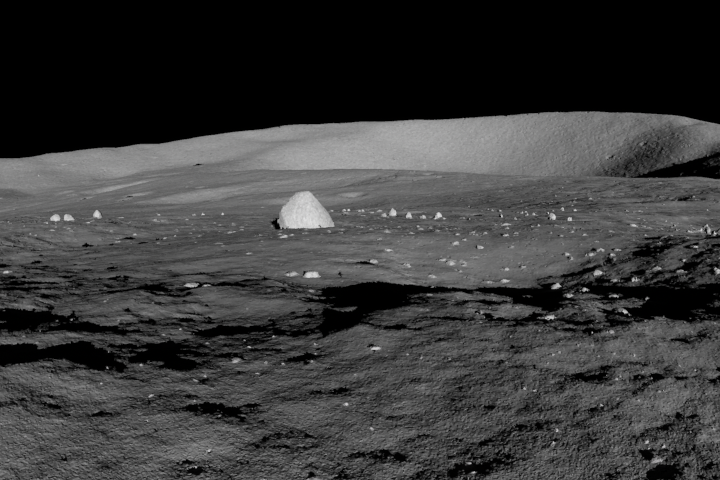

In [16]:
# Check the first image in images list --> Visualize it
Image.open(images[0])

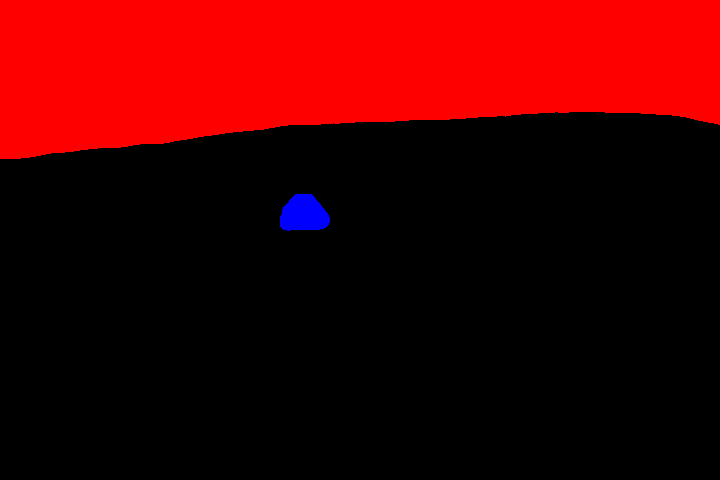

In [17]:
# Check the respective mask --> Visualize it
Image.open(masks[0])

In [18]:
# Check the shape of the image
Image.open(masks[0]).size

(720, 480)

### Originally, our images size is (720, 480) but we will reduce the size for better and faster processing. Since we are focusing on the clean masks so it will not effect much.

### Ground masks are more detailed and have so much noise. We'll keep things easy for our lecture. However, feel free to use ground masks and play around to explore more.

In [19]:
# Create H and W constants to save the height and the width of the image to pass to model and set it to 256
H = 256
W = 256

# Empty list to store preprocessed images and masks
X_img = []
y_mask = []

# Loop through each image and mask and implement the preprocessing steps
'''
Preprocessing Steps:-

For image:-
1. Resize the image to 256 x 256
2. Normalize the image
3. Keep the data type as float (values between 0 to 1)
For mask:-
1. Resize the mask
2. Keep the data type as integer (Values between 0 - 255)
'''
for x, y in (zip(images, masks)):
    # preprocess image
    img = cv2.imread(x, cv2.IMREAD_COLOR) # Reading the image
    img = cv2.resize(img, (W, H))         # Resizing into 256 x 256
    img = img / 255.0                     # Normalizing pixels between 0 and 1
    img = img.astype(np.float32)          # Making sure the image pixels data type stays float32

    # preprocess mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE) # Reading the respective mask
    mask = cv2.resize(mask, (W, H))            # Resizing it into 256 x 256
    mask = mask.astype(np.int32)               # Making sure that masks pixels are integers

    # append the image and mask to respective list
    X_img.append(img)
    y_mask.append(mask)


In [20]:
# Convert X_img and y_mask lists to numpy array
X_img = np.array(X_img)
y_mask = np.array(y_mask)

# 1600 datapoints as training dataset and 400 for validation dataset using slicing
X_train = X_img[:1600]
X_valid = X_img[1600:]

y_train = y_mask[:1600]
y_valid = y_mask[1600:]


In [21]:
# Check shape of X_train, y_train and X_valid, y_valid

data_tuple = (X_train, y_train, X_valid, y_valid)
data_name = ('X_train', 'y_train', 'X_valid', 'y_valid')

for data, name in zip(data_tuple, data_name):
    print(f'The shape of {name}:- {data.shape}')

The shape of X_train:- (1600, 256, 256, 3)
The shape of y_train:- (1600, 256, 256)
The shape of X_valid:- (400, 256, 256, 3)
The shape of y_valid:- (400, 256, 256)


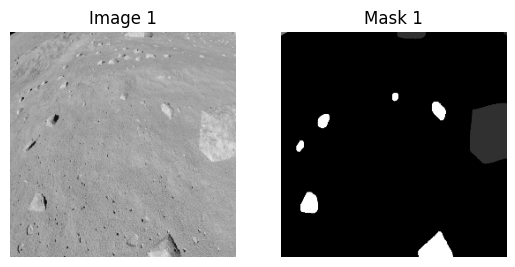

In [25]:
# Create a subplot to visualize image in X_train and respective y_train to see if everything is working fine
plt.subplot(1, 2, 1)
plt.imshow(X_train[1])
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train[1], cmap='gray')
plt.title('Mask 1')
plt.axis('off')

plt.show()

Check this article to know more about how to build optimized data pipeline using tf
https://www.tensorflow.org/guide/data_performance

# Data Pipeline

### One hot encoding

![](https://i.imgur.com/mtimFxh.png)

#### Similarly, we'll one hot encode our labels to 4 different channels for four classes

In [ ]:
'''
1. In sementic segmentation, each channel will have data for respective categories
2. That is, if small rocks is one category, then one channel will have small rocks labelled as 1 everything else as 0
3. Similarly, for bigger rocks as one category, there will be one channel with big rocks as 1, everything else as 0
4. Like this, you will have respective channels for sky and surface as well.
'''

In [64]:
batch_size = 4
num_classes = 4

'''Here the from_tensor_slices function is called to make dataset objects of our training and validation sets'''
# calling tf_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, tf.one_hot(y_train, num_classes, dtype=tf.float32)))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, tf.one_hot(y_valid, num_classes, dtype=tf.float32)))

Read more about prefetching and AUTOTUNE here: https://www.tensorflow.org/guide/data_performance#optimize_performance

## Naive Approach
![](https://www.tensorflow.org/guide/images/data_performance/naive.svg)


## After prefetching

![](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

In [65]:
# Batch the data and prefetch it
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [66]:
sample = iter(valid_dataset)
data = next(sample)
data[0].shape
# batch size, height, width, channels

TensorShape([4, 256, 256, 3])

In [58]:
data[1].shape
# batch size, height, width, channels/classes

TensorShape([4, 256, 256, 4])

## Creating U-net Architecture

**For Contracting Path:** the **conv_block** function is called four time which will create four block with pooling (pool = True). The process is repeated 3 more times.

**For Bridge:** the **conv_block** function is called one time without pooling (pool=False).

**For Expansive Path: UpSampling2D** is used to expands the size of images. This expanded  image is concatenated with the corresponding image from the contracting path, The reason here is to combine the information from the previous layers in order to get a more precise prediction. And now **conv_block** function is called without pooling (pool=False). The process is repeated 3 more times.

The last step is to reshape the image to satisfy our prediction requirements. The last layer is a convolution layer with 1 filter of size 1x1.

In [67]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

'''conv_block it is used to create one block with two convolution layer
followed by BatchNormalization and activation function relu.
If the pooling is required then Maxpool2D is applied and return it else not.'''
# function to create convolution block
def conv_block(inputs, filters, pool=True):
  x = Conv2D(filters, 3, padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
    
  if pool:
    p = MaxPool2D((2, 2))(x)
    return x, p
  else:
    return x

'''build_unet it is used to create the U-net architecture.'''
# function to build U-net
def build_unet(shape, num_classes):
    """ Input """
    inputs = Input(shape)
    
    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)


    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)
    
    """ Decoder """
    # Reference for UpSampling2D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D
    u1 = UpSampling2D((2, 2), interpolation='bilinear')(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)
    
    u2 = UpSampling2D((2, 2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)
    
    u3 = UpSampling2D((2, 2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)
    
    u4 = UpSampling2D((2, 2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)
    
    """ Output layer """
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8)

    return Model(inputs, output)

In [68]:
# Calling build_unet function
model = build_unet((256, 256, 3), num_classes)

# Get the model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_64[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ activation_65[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_69[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_66[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ activation_67[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 64, 64,    │     13,872 │ max_pooling2d_17… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        192 │ conv2d_71[0][0] 

 Total params: 599,412 (2.29 MB)

 Trainable params: 597,620 (2.28 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Load model and compile

In [41]:
# install segmentation_models to get iou_score from metrics
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [42]:
import os
import keras

os.environ["SM_FRAMEWORK"] = "tf.keras"

In [43]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score

sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


In [69]:
""" Hyperparameters """
lr = 1e-4
epochs = 5

"""Model"""
model.compile(loss="categorical_crossentropy",       # jacard loss (try it!), dice_loss
              optimizer=tf.keras.optimizers.Adam(lr),
              metrics=[iou_score])


train_steps = len(X_train)//batch_size
valid_steps = len(X_valid)//batch_size

In [45]:
print(train_steps)
print(valid_steps)

400
100


## Train model

In [70]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs
    )

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - iou_score: 0.1209 - loss: 0.5400 - val_iou_score: 0.1535 - val_loss: 0.2638
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - val_iou_score: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - iou_score: 0.1623 - loss: 0.2609 - val_iou_score: 0.1725 - val_loss: 0.2097
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - val_iou_score: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - iou_score: 0.1779 - loss: 0.1887 - val_iou_score: 0.1774 - val_loss: 0.1633


## Predict from model

In [81]:
# function to predict result
def predict_image(img_path, mask_path, model):
    H = 256
    W = 256
    num_classes = 4

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))   ## (256, 256)
    mask = np.expand_dims(mask, axis=-1) ## (256, 256, 1)
    mask = mask * (255/num_classes)
    mask = mask.astype(np.int32)
    mask = np.concatenate([mask, mask, mask], axis=2)

    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0] # (1, 256, 256, 3)
    pred_mask = np.argmax(pred_mask, axis=-1) # Output of pred_mask will be PROBABILITIES
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask * (255/num_classes)
    pred_mask = pred_mask.astype(np.int32)
    pred_mask = np.concatenate([pred_mask, pred_mask, pred_mask], axis=2)

    return img, mask, pred_mask

In [82]:
# function to display result
def display(display_list):
  plt.figure(figsize=(12, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Mask On Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


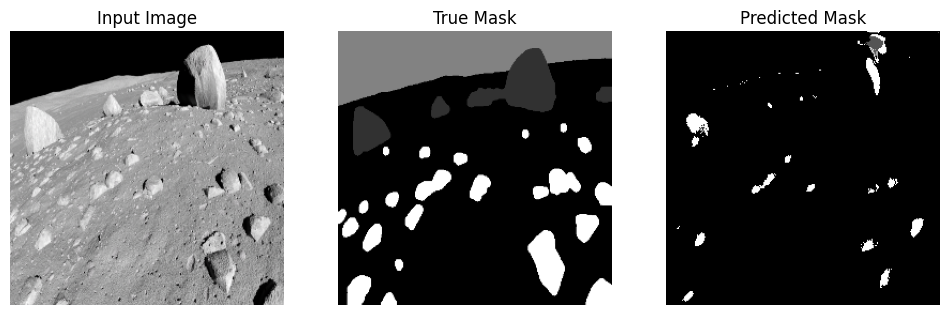

In [97]:
img_path = '/kaggle/input/images/render/render6000.png'
mask_path = '/kaggle/input/images/clean/clean6000.png'

img, mask, pred_mask = predict_image(img_path, mask_path, model)

display([img, mask, pred_mask])

## A practical note: different backbones in modern U-Nets

So far, you have looked at how the U-Net architecture was implemented in the original work by Ronneberger et al. Over the years, many people have experienced with different setups for U-Nets, including pretraining on e.g. ImageNet and then finetuning to their specific image segmentation tasks.

This means that today, you will likely use a U-Net that no longer utilizes the original architecture as proposed above - but it's still a good starting point, because the contractive path, expansive path and the skip connections remain the same.

**Common backbones for U-Net architectures these days are ResNet, ResNeXt, EfficientNet and DenseNet architectures. Often, these have been pretrained on the ImageNet dataset, so that many common features have already been learned. By using these backbone U-Nets, initialized with pretrained weights, it's likely that you can reach convergence on your segmentation problem much faster.**

That's it! You have now a high-level understanding of U-Net and its components sunglasses.

## In the next module, we will learn how you can use segmentation_models using Transfer learning to use UNet architecture with different pretrained models as backbone.